# Covid-19 Vaccines in California and their Impacts

## Data Analysis

### Hypothesis:
#### 1.	College towns had an impact on Covid-19 surges in 2020.
#### 2.	Vaccines have directly impacted California’s case and death rates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import gmaps

#import API key for gmaps
from config import gkey
gmaps.configure(api_key=gkey)

In [8]:
# import required dataframes:

clean_case = pd.read_csv('Data/clean_case.csv')
vaccine_df = pd.read_csv('Data/vaccine_df.csv')
ca_vaccinations = pd.read_csv('Data/ca_vaccinations.csv')
county_data = pd.read_csv('Data/county_data.csv')

## Research Analysis

### 1.	How has the introduction of the Covid vaccine affected case/death rate in California?

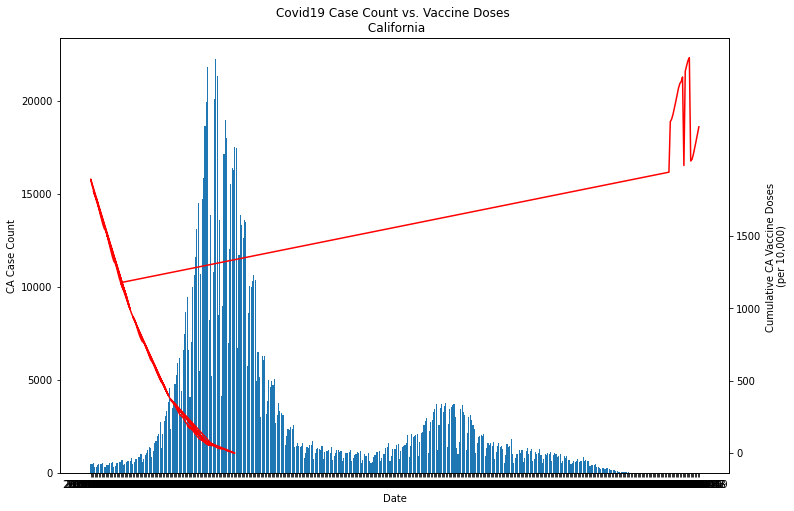

In [3]:
#Covid cases vs. vaccinations

#covid case & dates for bar graph
x1=(clean_case['date'])
y1=(clean_case['cases'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Case Count")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))
plt.title('Covid19 Case Count vs. Vaccine Doses \n California')
plt.savefig('Covid19_CaseCount_vs_Vaccine')
plt.show()

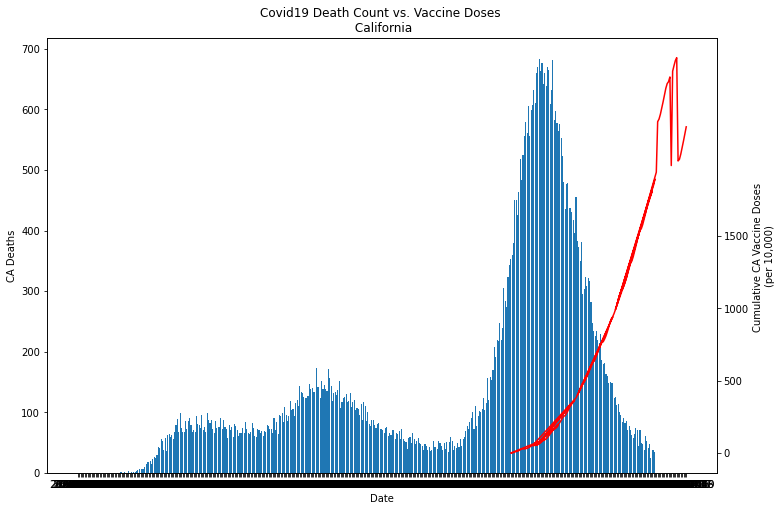

In [4]:
#covid deaths vs. vaccinations 
death_by_date = clean_case.groupby(['date'],as_index=False).agg({'deaths':['sum']})
death_by_date.columns = death_by_date.columns.droplevel(1)

#covid case & dates for bar graph
x1=(death_by_date['date'])
y1=(death_by_date['deaths'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Deaths")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.title('Covid19 Death Count vs. Vaccine Doses \n California')
plt.savefig('Covid19_DeathCount_vs_Vaccine')

plt.show()

### 2.	Do “College” towns play a larger role in case surges?

In [5]:
#Grabbing 3rd quartile for heatmap max intensities
county_data.quantile(0.75)

# Locating all counties in the top quartile as "College Counties"
college_counties = county_data.loc[county_data['% student population']>=7.425]
len(college_counties)

15

In [6]:
# Creating heat map of Covid-19 cases

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = county_data['cases per 100,000']

fig1 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_cases = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_cases.max_intensity = 9283
heatmap_layer_cases.point_radius = 0.25

fig1.add_layer(heatmap_layer_cases)

#add college counties to the 2020 heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{cases per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig1.add_layer(markers)

# Display figure

fig1

Figure(layout=FigureLayout(height='420px'))

The above heatmap was originally broken down by year to see the affect of lower student populations due to virtual learning. However, the maps were identical. This also suggests that each county is maintaining it's own Covid-19 curve. No county appears to have dramatically changed its numbers between 2020 and 2021.

In [7]:
# Creating heat map of Vaccines

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = county_data['Fully Vaccinated per 100,000']

fig3 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_vaccines = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_vaccines.max_intensity = 30233
heatmap_layer_vaccines.point_radius = 0.25
heatmap_layer_vaccines.gradient = [(255,0,0, 0),
                                   (255,0,0, 1),
                                   (255,255,0, 1),
                                   (0,255,0, 1)]

fig3.add_layer(heatmap_layer_vaccines)

#add college counties to the Vaccine heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{Fully Vaccinated per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig3.add_layer(markers)

# Display figure

fig3

Figure(layout=FigureLayout(height='420px'))

Inverted colors on Vaccines heat map as a greater number of vaccines per 100,000 people is considered good.

### 3.	Are there “Vaccination Deserts”? What impact have Covid-19 and the vaccines had in these areas?

### 4.	Can we predict when California will return to “normal”?